# 3D SETUP FOR THE PRACTICAL IRS CASE

User positions:
 [[  15.49025012  -28.27180481    0.        ]
 [ -30.74462256  300.15049392    0.        ]
 [  -2.71377409  -69.01096676    0.        ]
 [  20.91925178   32.24443937    0.        ]
 [ -89.62996101 -170.37316001    0.        ]
 [ 295.96344966  -47.01972115    0.        ]
 [ 217.29779053 -347.76689231    0.        ]
 [-195.75343958   18.38973619    0.        ]
 [ -20.91993812  -27.72689153    0.        ]
 [  -6.10213388  -11.50012886    0.        ]
 [ -17.9632875    -3.66933895    0.        ]]

Distances b/w the antennas and the users:
 [[ 51.67315539 282.00980667  89.61203476  26.22101048 210.65485981
  303.62148566 427.28306408 196.01531078  53.06128519  33.60794781
   31.35151199]]
(1, 11)

Distances b/w the IRS/IRS elements and the users:
 [[ 29.06259175 304.45087801  72.82465571  32.64276847 202.65918042
  279.98514448 399.8665164  216.59346827  49.68121647  28.95817337
   38.46656569]]
(1, 11)

Distances b/w the antennas and the IRS/IRS elements:
 28.722838454150274

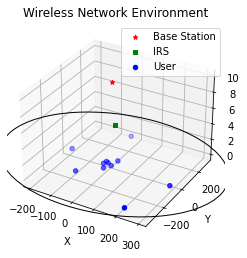

In [88]:
import matplotlib.pyplot as plt
import numpy as np 
import cmath
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d

from Functions import *

#============== System parameters
Nt = 1 #Number of antennas on the BS
nIRSrow = 2 #Total IRS row elements
nIRScol = nIRSrow #Total IRS column elements
Ns = nIRSrow*nIRScol #Total IRS elements
K = 11 #Number of users
f = 2e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
# N0 = db2pow(-174-30)
# B = 20e6
# sigma = np.sqrt(B*N0)
# epsilon = 1e-3
# Xi = 0.001
# relChange = 1e3
# iIter = 0
# objSeq = []

GRID_RADIUS = 500
BASE_STATION_POSITION = (0, 20, 10)
TRANSMIT_POWER_WATTS = 2 #in watts
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
PATH_LOSS_EXPONENT = 3.5 #path loss exponent (direct)
BETA = 2 #path loss exponent (indirect)
BANDWIDTH = 50*(10**6) #in Hz
m = 1
omega = 1.0

IRS_POSITION = (20, 0, 5)
NUM_SIMULATIONS = 100

# threshold_min = 11.5
# threshold_max = 28.5

# Generate user positions
user_positions = generate_user_positions_3D(K, GRID_RADIUS)
print('User positions:'"\n", user_positions)
print()
loc_U = user_positions
# print(loc_U)

# Generate antennas position
antenna_position = generate_station_positions_3D(BASE_STATION_POSITION)
xt, yt, zt = antenna_position[0]

# Generate IRS position
irs_position = generate_IRS_3D(IRS_POSITION)
xs, ys, zs = irs_position[0]

tx_ant_coords = generate_transmit_antenna_coordinates_3D(Nt, xt, yt, zt, halfLambda, quarterLambda)
loc_T = tx_ant_coords
# print(loc_T)

irs_coords = generate_irs_coordinates_3D(xs, ys, zs, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S = irs_coords
# print(loc_S)

dTU, dSU, dTS = calculate_distances_3D(loc_U, loc_T, loc_S)

# Reshapiing the distance from antennas/BS to user
dTU = dTU.reshape(Nt,K)
# Compute row-wise averages
dSU = np.mean(dSU, axis=1, keepdims=True)
dSU = dSU.reshape(1,K)
# Compute the sum of elements in each row
dTS = np.sum(dTS, axis=1)
# Compute the average of row sums
dTS = np.mean(dTS)

print('Distances b/w the antennas and the users:'"\n", dTU)
print(np.shape(dTU))
print()
print('Distances b/w the IRS/IRS elements and the users:'"\n", dSU)
print(np.shape(dSU))
print()
print('Distances b/w the antennas and the IRS/IRS elements:'"\n", dTS)
print(np.shape(dTS))

h_dk = []
h_rk = []
h_rk_transpose = []
G = []

# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk1 = []
    fading1 = []
    for user in range(K):
        fading1.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    h_dk1 = np.array(fading1)
    h_dk1 = h_dk1.reshape(Nt,K)
    h_dk.append(h_dk1)
    
    # Generate the Nakagami Channel from each user to the IRS (h_rk)
    h_rk1 = []
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m, omega, Ns))
    h_rk1 = np.array(fading)
    h_rk1 = h_rk1.reshape(Ns,K)
    h_rk.append(h_rk1)
    
    h_rk_conj = np.conj(h_rk1)
    h_rk_transpose1 = np.transpose(h_rk_conj)
    h_rk_transpose.append(h_rk_transpose1)
    
    # Generate the Nakagami Channel from base_station to the IRS (G)
    G1 = []
    fading2 = []
    for element in range(Ns):
        fading2.append(generate_nakagami_samples(m, omega, Nt))
    G1 = np.array(fading2)
    G.append(G1)

# Convert 3D arrays to 2D arrays by averaging along axis 0
h_dk = (np.mean(h_dk, axis=0))
h_rk = (np.mean(h_rk, axis=0))
h_rk_transpose = (np.mean(h_rk_transpose, axis=0))
G = (np.mean(G, axis=0))

# Plot the 3D grid, base station, IRS, and user positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
ax.scatter(IRS_POSITION[0], IRS_POSITION[1], IRS_POSITION[2], color='green', marker='s', label='IRS')
ax.scatter(user_positions[:, 0], user_positions[:, 1], color='blue', marker='o', label='User')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Wireless Network Environment')
ax.legend()
ax.grid(True)

# Draw the circle in the x-y plane
circle = plt.Circle((xt, yt), (GRID_RADIUS), edgecolor='black', facecolor='none')
ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(circle, z=0, zdir='z')  # Add the circle to the x-y plane at z=zt
plt.show()

# SISO IDEAL PHASE SHIFT MODEL WITH IDEAL PHASE SHIFTS (MULTIPLE USERS)

In [89]:
RATE_THRESHOLD = 30

# Initialize an empty list to store theta_n values for each i
theta_n_values_complex = []

for i in range(K):
    
    theta_n_i = []
    
    for j in range(Ns):
        
        theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
        
        # Adjust theta_n to lie within the range (-π, π)
        theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
        theta_n_i.append(theta_n)
        
    theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))

theta_n_values_complex = np.array(theta_n_values_complex)
# print('Theta_n matrix: ',"\n", theta_n_values_complex)
# print(np.shape(theta_n_values_complex))
# print()

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))
# print()

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
# print('Results array: '"\n", results_array)
# print
# print('Shape of results array:', results_array.shape) 
# print()
results_array = results_array.reshape(1,K)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# # Print link budget values
# print('Link Budget: ') 
# for element in link_budget:
#     print(element)
# print(np.shape(link_budget)) 
# print() 

# # Print SNR values
# print('SNR of all users (in dB): ')
# for element in SNR_matrix:
#     print(element)
# print(np.shape(SNR_matrix)) 
# print() 

# Print rate values
# print('Rate of all users (in bps/Hz): ')
# for element in rate_matrix:
#     print(element)
# print(np.shape(rate_matrix)) 

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))


Sum rate: 
 392.6743013416235

Outage probability for the simulated environment: 0.09091


# SISO IDEAL PHASE SHIFT MODEL WITH DISCRETE PHASES (MULTIPLE USERS)

In [91]:
# Create a set of quantized theta values

B = 3 # Quantization bit
quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
print('Quantized_theta_set: ',"\n", (quantized_theta_set))

quantized_theta_n_values_complex = []

for i in range(K):
    
    quantized_theta_n_i = []
    
    for j in range(Ns):
        
        theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
        
        # Find the nearest quantized theta value
        nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
        
        # Adjust theta_n to lie within the range (-π, π)
        nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi

        quantized_theta_n_i.append(nearest_quantized_theta_new)
    
    quantized_theta_n_values_complex.append(1 * np.exp(1j * np.array(quantized_theta_n_i)))

quantized_theta_n_i = np.array(quantized_theta_n_i)

theta_n_values_complex = np.array(quantized_theta_n_values_complex)
# print('Theta_n matrix: ',"\n", (theta_n_values_complex))
# print(np.shape(theta_n_values_complex))

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
results_array = results_array.reshape(1,K)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# Compute average outage probability
print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

# Compute average outage probability
print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Quantized_theta_set:  
 [-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449]

Sum rate: 
 392.6619550941358

Outage probability for the simulated environment: 0.09091


# SISO PRACTICAL PHASE-DEPENDENT AMPLITUDE PHASE SHIFT MODEL WITH IDEAL PHASE SHIFTS (MULTIPLE USERS)

In [92]:
# Practical phase shift model parameters
beta_min = 0.2
k = 1.6
phi = 0.43 * np.pi

theta_n_values_complex = []
theta_n_vals = []

for i in range(K):
    beta_n = []
    theta_n_i = []
    for j in range(Ns):
        theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
        
        # Adjust theta_n to lie within the range (-π, π)
        theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
        theta_n_i.append(theta_n)
        
        beta_theta_n = ((1 - beta_min) * ((np.sin(theta_n - phi) + 1) / 2) ** k + beta_min)
        beta_theta_n = np.clip(beta_theta_n, 0, 1)
        beta_n.append(beta_theta_n)
    
    theta_n_vals.append(theta_n_i)
    theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(theta_n_i)))
    
theta_n_values_complex = np.array(theta_n_values_complex)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
results_array = results_array.reshape(1,K)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))


Sum rate: 
 392.6670877206984

Outage probability for the simulated environment: 0.09091


# SISO PRACTICAL PHASE-DEPENDENT AMPLITUDE PHASE SHIFT MODEL WITH QUANTIZED PHASE SHIFTS (MULTIPLE USERS)

In [86]:
# Initialize an empty list to store quantized theta_n values for each i
quantized_theta_n_values_complex = []

for i in range(K):
    
    beta_n = []
    quantized_theta_n_i = []
    
    for j in range(Ns):
        theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
        
        # Find the nearest quantized theta value
        nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
        
        # Adjust theta_n to lie within the range (-π, π)
        nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi

        quantized_theta_n_i.append(nearest_quantized_theta_new)
        
        beta_theta_n = ((1 - beta_min) * ((np.sin(nearest_quantized_theta_new - phi) + 1) / 2) ** k + beta_min)
        beta_theta_n = np.clip(beta_theta_n, 0, 1)
        beta_n.append(beta_theta_n)
    
    quantized_theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(quantized_theta_n_i)))
    
theta_n_values_complex = np.array(quantized_theta_n_values_complex)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
results_array = results_array.reshape(1,K)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

# # Compute the outage probability
outage_probability = 0.0
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))


Sum rate: 
 360.9578727979542

Outage probability for the simulated environment: 0.54545
